<a href="https://colab.research.google.com/github/bwsi-hadr/04-Intro-to-networks/blob/master/04_Intro_to_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Networks
The study of networks investigates the relationship between discrete objects using [graphs](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics))

![network_diagram](https://upload.wikimedia.org/wikipedia/commons/2/2f/Small_Network.png)

Graphs are a mathematical structure which represent a set of objects (called nodes or vertices) as well as their symmetric or asymmetric relationships (called links or edges).

They can be used to represent both physical systems (roads, pipelines, electrical grid) and abstract systems (social, collaboration, genetics).

For this course, we'll be using the python `networkx` package, which provides many useful classes and functions for representing and doing computations with networks. 

In addition, we'll be using the `osmnx` package, which will download openstreetmap road networks as `networkx` objects. There are a ton of useful examples in the [examples repo](https://github.com/gboeing/osmnx-examples).

This lecture is based off of the [osmnx-examples](https://github.com/gboeing/osmnx-examples) code and the [Automating GIS Processes](https://automating-gis-processes.github.io/2018/notebooks/L6/retrieve_osm_data.html) course.

In [14]:
import networkx as nx # need networkx >= 2.5
import osmnx as ox
import contextily as ctx 
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
import folium
import numpy as np
import matplotlib.patches as mpatches
import geopandas as gpd
from shapely.ops import nearest_points

In [ ]:
# Specify the name that is used to seach for the data
place_name = "Cambridge, MA, USA"

# Fetch OSM street network from the location
# this will take a while because there's a lot of streets
graph = ox.graph_from_place(place_name)

In [ ]:
# metadata about the graph object
graph.graph

In [ ]:
# we can save the graph to a file so that we don't have to
# wait for it to download again next time
ox.io.save_graphml(graph, 'cambridge_osmnx.graphml')

In [ ]:
# loading graph from a file
graph = ox.io.load_graphml('cambridge_osmnx.graphml')

In [ ]:
# Let's take a look at the graph
fig, ax = ox.plot_graph(graph)

In [ ]:
# we can project the graph into epsg:3857 so that units are in meters
# using the .project_graph() function; 
# by default, osmnx graphs are created in WGS84, (epsg:4326)
graph_proj = ox.project_graph(graph, to_crs='epsg:3857')

In [ ]:
# we can then convert the projected graph to a geodataframe
graph_nodes_gdf, graph_edges_gdf = ox.graph_to_gdfs(graph_proj)
graph_nodes_gdf.crs

In [ ]:
graph_nodes_gdf

In [ ]:
graph_edges_gdf

In [ ]:
# we can also get a gdf for the footprint of the place
place_footprint = ox.geocode_to_gdf(place_name)
graph_area = place_footprint.to_crs('epsg:3857')
graph_area

In [ ]:
graph_area.plot()

## Exercises
What is the total area of cambridge in sq meters?

In [ ]:
print("area: ",graph_area.loc[0,'geometry'].area)

How many street segments in Cambridge are longer than 100 meters?

In [ ]:
len(graph_edges_gdf[graph_edges_gdf['length'] > 100]) #cant use the .length function 


## Road network statistics

In [ ]:
# we can get basic stats about the network:
ox.stats.basic_stats(graph_proj)

Circuity is the ratio of network distance (distance traveled along roads) to euclidean distance (straight line). Higher circuity means greater inefficiency in traveling along the roads.

Check the [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats) for more info about each statistic

In [ ]:
# if you pass in the area, you can get density info
area_cambridge_sqm = graph_area['geometry'].area
ox.basic_stats(graph_proj, area=area_cambridge_sqm)

## Getting data other ways
In the above example, we used the name of a place to get the data that we wanted.

However, there are other ways to specify locations which may be more convenient.

For example, you can get [graphs from address](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=poly#osmnx.core.graph_from_address), [bounding box](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=poly#osmnx.core.graph_from_bbox), [points](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=poly#osmnx.core.graph_from_bbox), or [shapely polygon object](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=poly#osmnx.core.graph_from_polygon)

The types of networks you can get are:

-    `drive` - get drivable public streets (but not service roads)
-    `drive_service` - get drivable streets, including service roads
-    `walk` - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
-    `bike` - get all streets and paths that cyclists can use
-    `all` - download all non-private OSM streets and paths
-    `all_private` - download all OSM streets and paths, including private-access ones



In [ ]:
# Coordinates of the MIT main campus in Decimal Degrees
coordinates = [(-71.092562, 42.357602), (-71.080155, 42.361553),
               (-71.089817, 42.362584), (-71.094688, 42.360198)]

# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)

# convert to meters from latlong by projecting to epsg:3857
poly_m, poly_crs_m = ox.projection.project_geometry(poly, to_crs='epsg:3857')

# put a buffer of 1 mile (1609.34 m) to get everything w/in 1 mile
poly_with_buffer_m = poly_m.buffer(1609.34)

# convert back to lat-long
poly_with_buffer_ll, poly_crs_ll = ox.projection.project_geometry(poly_with_buffer_m, 
                                                        crs=poly_crs_m, 
                                                        to_crs='epsg:4326', 
                                                        to_latlong=True)

'''
# get all walkable roads within poly
walkable_roads_near_mit = ox.graph_from_polygon(poly_with_buffer_ll, 
                                       network_type='walk',
                                       clean_periphery=True)
'''
# Get all walkable roads within poly
walkable_roads_near_mit = ox.graph_from_polygon(
    poly_with_buffer_ll, 
    network_type='walk'
)


In [ ]:
# let's plot it
fig, ax = ox.plot_graph(walkable_roads_near_mit, figsize=(8,10), node_size=10)

In [ ]:
# example of a road
all_edges_list = list(walkable_roads_near_mit.edges) # put the id for each edge in a list
print(all_edges_list[0]) # id of first edge
print(walkable_roads_near_mit.edges[all_edges_list[0]]) # get details for first edge

In [ ]:
# get attribute for all edges
walkable_roads_near_mit.edges(data='name')

In [ ]:
# example of a node (intersection)
all_nodes_list = list(walkable_roads_near_mit.nodes)
print(all_nodes_list[0]) # id of first node
print(walkable_roads_near_mit.nodes[all_nodes_list[0]]) # details for first node

In [ ]:
# get attribute for all nodes
walkable_roads_near_mit.nodes(data='street_count')

## Exercise

How many walkable roads near MIT are longer than 100 meters?

In [ ]:
total = 0
for i in walkable_roads_near_mit.edges(data = 'length'):
    if i[-1] > 100:
        total += 1
print("there are ", total,  " walkable roads near MIT longer than 100 meters")

"""
can also do

walkable_roads_near_mit_m = ox.project_graph (walkable_roads_near _mit, to_crs='epsg:3857')
_, mit_edges_m = ox.graph_to_gdfs (walkable_roads_near_mit_m)
mit_edges _m[mitLedges_m['length'] > 100]

 OR
 sum (map (lambda x: 1 if x[-1] > 100 else 0, walkable_roads_near _mit.edges(data='length' )))
 """

## Routing
We can get the node closest to a point using the `ox.distance.nearest_node` function.

In [ ]:
orig_node = ox.distance.nearest_nodes(walkable_roads_near_mit, -71.092562, 42.357602)

# let's calculate the route to a random destination node
rand_node = np.random.choice(walkable_roads_near_mit.nodes)
print(walkable_roads_near_mit[rand_node])

'''
route = ox.distance.shortest_path(walkable_roads_near_mit, 
                         orig_node, rand_node, 
                         weight='length')
'''
route = ox.routing.shortest_path(walkable_roads_near_mit, 
                         orig_node, rand_node, 
                         weight='length')

fig, ax = ox.plot_graph_route(walkable_roads_near_mit, route, node_size=0)
shortest_path_length = nx.shortest_path_length(walkable_roads_near_mit, orig_node, 
                              rand_node, weight='length')
print(f'length of shortest walkable path from node {orig_node} to {rand_node} is {shortest_path_length:.2f}m') # the {:.2f} syntax means round off to 2 digits after decimal pt

The `shortest_path` function in networkx uses [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) to efficiently calculate the shortest path between two nodes. The networkx library also provides many other useful functions on graphs; for instance, the [Floyd-Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm), which efficiently computes the shortest paths between all pairs of nodes, and the [A* (A-star) algorithm](https://en.wikipedia.org/wiki/A*_search_algorithm), which is similar to Dijkstra's algorithm, except it runs faster by taking advantage of a distance "approximation" that can be calculated between two nodes without knowing the shortest path outright. Check out these links if you want to learn more about these algorithms, and check out the [networkx documentation](https://networkx.github.io/documentation/networkx-2.4/index.html) if you want to learn more about all the methods networkx provides.

## Building outlines
We can get the footprint of objects such as buildings as geodataframes with `osmnx`. Here we'll get the building footprints near MIT.

In [ ]:
'''
# we can get the footprints of objects within this poly
building_footprints = ox.geometries.geometries_from_polygon(poly_with_buffer_ll, tags={'building':True})
'''
# we can get the footprints of objects within this poly
building_footprints = ox.features.features_from_polygon(poly_with_buffer_ll, tags={'building':True})


You can perform any query using OSM tags: https://wiki.openstreetmap.org/wiki/Map_features

Note that if you include multiple tags, it gets the **union** of the results, not the intersection

In [ ]:
'''
road_footprints = ox.geometries.geometries_from_polygon(poly_with_buffer_ll, tags={'highway':True}) # get roads with geometry
# note that most roads do not have footprint information
'''
road_footprints = ox.features.features_from_polygon(poly_with_buffer_ll, tags={'highway':True}) # get roads with geometry
# note that most roads do not have footprint information

In [ ]:
# project into UTM for info in meters
building_footprints_proj = ox.projection.project_gdf(building_footprints)
road_footprints_proj = ox.projection.project_gdf(road_footprints)
building_footprints_proj

In [ ]:
# column names
building_footprints_proj.columns.values

In [ ]:
# drop rows where there's no shape info
building_footprints_proj = building_footprints_proj.dropna(subset=['geometry'])
road_footprints = road_footprints.dropna(subset=['geometry'])

In [ ]:
fig, ax = ox.plot_footprints(building_footprints_proj)

In [ ]:
# plot roads with footprints
fig, ax = ox.plot_footprints(road_footprints_proj) # note that this is only a small subset of all roads

In [ ]:
# save the geodataframe to a file to persist
# can choose to write only a subset of columns if you want
building_footprints_proj[['description', 'operator', 'railway', 'geometry', 'attribution',
       'source', 'addr:city', 'addr:housenumber', 'addr:postcode',
       'addr:state', 'addr:street', 'amenity']].to_file('buildings_around_mit.geojson', driver='GeoJSON')


# Exercises
Plot the walkable roads and buildings in the area near MIT in the same figure. The `osmnx` plotting features use matplotlib on the backend. Check [the documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.plot.plot_graph) for more formatting options for plotting

In [ ]:
"""
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(walkable_roads_near_mit, ax=ax, node_size=0, edge_color='salmon', edge_linewidth=0.5)
ox.plot_footprints(building_footprints_proj, ax=ax, linewidth=0, facecolor='salmon', alpha=0.7)
"""
#fig = plt.figure()
#ax = fig.subplots(1,1)
import pandas as pd

my_gdf = pd.concat((building_footprints_proj, road_footprints_proj), join = 'inner')
ox.plot_footprints(my_gdf)

Now, go back to one of the previous exercises and plot all the nodes on the periphery of Cambridge and the roads in Cambridge in the same figure.

In [ ]:
"""
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(10, 10))
#graph
graph = ox.io.load_graphml('cambridge_osmnx.graphml')
# find ice cream
ice_cream_places = ox.geometries_from_place('Cambridge, MA', tags={'amenity': 'ice_cream'})
# show ice cream
ox.plot_footprints(ice_cream_places, ax=ax)
# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Ice-cream shops'),
    mpatches.Patch(color='lightgrey', label='Cambridge, MA', edgecolor='black')
]
ax.legend(handles=legend_elements)
# Adjust aspect ratio
ax.set_aspect('auto')
plt.show()
from shapely import plotting

cambridge_gdf = ox.geocode_to_gdf('Cambridge, MA, USA' )
cambridge_poly = cambridge_gdf.loc[0,'geometry']

fig = plt.figure()
ax = fig.subplots(1,1)

# ax.set xlim(cambridge poly.bounds[0], cambridge poly.bounds [2])
# ax.set _ylim(cambridge_poly.bounds [1], cambridge_poly.bounds [3])

ax.add_patch(plotting.patch_from_polygon(cambridge_poly, alpha=0.3))
ax = ox.features.features_from_polygon(cambridge_poly, tags={'amenity':'ice cream'}).plot(ax=ax)
ctx.add_basemap(ax, crs= cambridge_gdf.crs)
"""

## Interactive graph with folium
Folium is a library which creates interactive web maps. This can be used to visualize and explore the data. However, it is slower to load and cannot scale to as large networks as the standard matplotlib plotting

In [ ]:
'''
folium_graph = ox.plot_graph_folium(walkable_roads_near_mit)
folium_graph
'''
import osmnx as ox
# pip install folium matplotlib mapclassify
# Convert the walkable roads graph to GeoDataFrames
graph_nodes_gdf, graph_edges_gdf = ox.graph_to_gdfs(walkable_roads_near_mit)

# Use the explore method to create an interactive web map
map_edges = graph_edges_gdf.explore()

# Optionally, you can save the map to an HTML file to view it in a browser
map_edges.save('walkable_roads_near_mit.html')

# To display the map in a Jupyter notebook
map_edges


In [ ]:
'''
ox.plot_route_folium(walkable_roads_near_mit, route, route_map = folium_graph, color='#ff0000')
'''
import geopandas as gpd
from shapely.geometry import LineString


# Extract the route geometry
route_nodes_gdf = graph_nodes_gdf.loc[route]
route_line = LineString(route_nodes_gdf.geometry.tolist())

# Create a GeoDataFrame for the route
route_gdf = gpd.GeoDataFrame(geometry=[route_line], crs=graph_edges_gdf.crs)

# Add the route to the map
map_edges = route_gdf.explore(m=map_edges, color='#ff0000', tooltip=False)

# To display the map in a Jupyter notebook
map_edges


## Get places of interest
OSM can also give places of interest, like restaurants, pharmacies, hospitals, and toilets. The full list is available [here](https://wiki.openstreetmap.org/wiki/Key:amenity).

Let's look at the POIs near MIT.

In [ ]:
'''
fast_food = ox.geometries.geometries_from_polygon(poly_with_buffer_ll, tags={'amenity': 'fast_food'})
'''
fast_food = ox.features.features_from_polygon(poly_with_buffer_ll, tags={'amenity': 'fast_food'})
fast_food

In [ ]:
walkable_nodes, walkable_edges = ox.graph_to_gdfs(walkable_roads_near_mit)

In [ ]:
# plot roads, buildings, and fast_food
fig, ax = plt.subplots(1,1, figsize=[20,20])
building_footprints.plot(ax=ax)
walkable_edges.plot(ax=ax, color='black')
fast_food.plot(ax=ax, color='#FF0099', markersize=50)
plt.show()

# Exercise
In groups, pick a location, ask an interesting question, do an analysis to answer that question.


In [7]:
import pandas as pd
df_crime = pd.read_csv('2020-01-metropolitan-street.csv')

In [8]:
#first dataset- london crime rates 
#clean the data
#drop empty rows 
df_crime = df_crime.dropna(subset=['LSOA name','Longitude','Latitude','Crime ID'])

#cut off the number code for burroughs 
#df_crime['LSOA name'] = df_crime['LSOA name'].apply(lambda x: x.split('0')[0])

"""# Function to remove numerical values from strings without using regex
def remove_numbers(s):
    return ''.join([char for char in s if not char.isdigit()])
"""
# Function to remove anything after the first numerical value in the string
def remove_after_first_number(s):
    for i, char in enumerate(s):
        if char.isdigit():
            return s[:i]
    return s

# Apply the function to the 'LSOA name' column using .loc
df_crime.loc[:, 'LSOA name'] = df_crime['LSOA name'].apply(remove_after_first_number)

# Ensure all 'LSOA name' values are stripped of leading/trailing whitespace
df_crime.loc[:, 'LSOA name'] = df_crime['LSOA name'].str.strip()

# Display the updated DataFrame to verify the changes
print(df_crime)

                                                Crime ID    Month  \
0      24c2b43c34c7cd6ef847d69fbb042c9c730b1eebe95c52...  2020-01   
9      8b0849f95d59f75cf481e974839ad311a42d139e8fdc24...  2020-01   
10     701106a99d1d5d4cb1d3bd04afbc0449d4339a2a7c89d0...  2020-01   
11     8b0849f95d59f75cf481e974839ad311a42d139e8fdc24...  2020-01   
12     1b95763f15c9d067c0545b0fab4466e92e2aea8d083aaf...  2020-01   
...                                                  ...      ...   
90430  b769321f36b7a7bfa6c30e32d6270cf62cdb11b0fbd646...  2020-01   
90431  f058b2b6bd424603ca8ae331a5c5f875795eedb6a8608b...  2020-01   
90432  b712f09c9bcd3abcd2d8f8368b6261a71340dbdfca505b...  2020-01   
90433  0e1d53228d6f87a398db9ba073993718e749bd62ad00ae...  2020-01   
90434  b769a8884d5f48d5653bc15865ac2ed20cacb5bdb6a314...  2020-01   

                       Reported by                 Falls within  Longitude  \
0      Metropolitan Police Service  Metropolitan Police Service  -0.539301   
9      Metropol

In [9]:
#group all the data per burrough together 
df_crime.groupby(['LSOA name']).count()


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,Crime type,Last outcome category,Context
LSOA name,,,,,,,,,,,
Arun,1,1,1,1,1,1,1,1,1,1,0
Barking and Dagenham,1569,1569,1569,1569,1569,1569,1569,1569,1569,1569,0
Barnet,2475,2475,2475,2475,2475,2475,2475,2475,2475,2475,0
Basildon,2,2,2,2,2,2,2,2,2,2,0
Bedford,3,3,3,3,3,3,3,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...
Windsor and Maidenhead,2,2,2,2,2,2,2,2,2,2,0
Woking,3,3,3,3,3,3,3,3,3,3,0
Wolverhampton,1,1,1,1,1,1,1,1,1,1,0


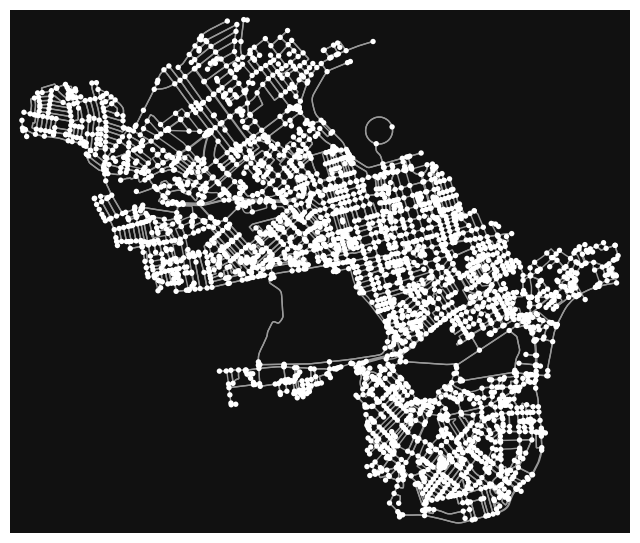

NameError: name 'geometry' is not defined

In [16]:
from shapely import Point



#plotting
"""
for i in df_crime['LSOA name']:
    place_name = i + " , England, United Kingdom"
    graph = ox.graph_from_place(place_name, network_type='drive')
    ox.io.save_graphml(graph, 'london_ox.graphml')
    graph = ox.io.load_graphml('london_ox.graphml')
    fig, ax = ox.plot_graph(graph)
"""
# Specify a smaller area within London
place_name = "Westminster, England, United Kingdom"
# Fetch OSM street network for the specified area
graph = ox.graph_from_place(place_name, network_type='drive')
# Save and load the graph
ox.io.save_graphml(graph, 'Westminster.graphml')
graph = ox.io.load_graphml('Westminster.graphml')
# Plot the graph
fig, ax = ox.plot_graph(graph)

#color coding for diff values 
#df_westminster = df_crime.loc[df_crime['LSOA name']=='Westminster']

# Filter the rows where 'LSOA name' is 'Westminster'
westminster_rows = df_crime[df_crime['LSOA name'] == 'Westminster']
westminster_rows

lo = westminster_rows['Longitude']
la = westminster_rows['Latitude']


geo_df = gpd.GeoDataFrame(geometry = geometry)

geometry = [Point(xy) for xy in zip(df_crime['Longitude'], df_crime['Latitude'])]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the points
geo_df.plot(ax=ax, markersize=20, color='red', marker='*', label='Crime Locations')

# Add title and labels
plt.title('Crime Locations on Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show legend
plt.legend()

# Display the plot
plt.show()


"""
geometry = [Point(xy) for xy in zip(lo,la)]
geo_df = gpd.GeoDataFrame(geometry = geometry)
print(geo_df)
g = geo_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*',label = 'Map')
plt.show()
"""


In [17]:
import folium
folium_graph = ox.plot_graph_folium(graph)

""" DO NOT USE for _, row in westminster_rows.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']]
       # popup=row.get('', ''),  # Adjust 'name' to the appropriate column name for popup text
    ).add_to(folium_graph)
"""
"""
# Create a list of shapely Point objects and add them to the map if they are within the boundary
for idx, row in westminster_rows.iterrows():
    point = Point(row['Longitude'], row['Latitude'])
    if point.within(boundary.unary_union):
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=3,  # Radius of the circle marker
            color='red',  # Border color
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            popup=row['LSOA name']
   ).add_to(folium_graph)

# Fetch the boundary of Westminster
place_name = "Westminster, England, United Kingdom"
boundary = ox.geocode_to_gdf(place_name)

# List of amenities to fetch and their colors for plotting
amenities = {'school': 'blue', 'college': 'blue', 'university': 'blue',
    'police': 'black', 'fire_station': 'red', 'post_office': 'purple',
    'bus_station': 'orange', 'taxi': 'yellow', 'ferry_terminal': 'blue',
    'park': 'lightgreen', 'playground': 'pink', 'sports_centre': 'red', 'stadium': 'blue',
    'restaurant': 'yellow', 'cafe': 'brown', 'bar': 'orange', 'bank': 'blue', 'marketplace': 'purple'
}

amenities_data = {}

for amenity, color in amenities.items():
    try:
        if amenity in ['park', 'playground', 'sports_centre', 'stadium']:
            tags = {'leisure': amenity}
        else:
            tags = {'amenity': amenity}
        amenities_data[amenity] = ox.features_from_place(place_name, tags)
        amenities_data[amenity] = amenities_data[amenity][amenities_data[amenity].geometry.type == 'Point']
    except Exception as e:
        print(f"Error fetching {amenity}: {e}")
        amenities_data[amenity] = gpd.GeoDataFrame()  # Create an empty GeoDataFrame
folium_graph
"""
# Create a Folium map centered around Westminster
map_center = [boundary.geometry.iloc[0].centroid.y, boundary.geometry.iloc[0].centroid.x]
folium_graph = folium.Map(location=map_center, zoom_start=13)

# Add the boundary of Westminster to the map
folium.GeoJson(boundary).add_to(folium_graph)

# Plot crime locations on the map
for idx, row in westminster_rows.iterrows():
    point = Point(row['Longitude'], row['Latitude'])
    if point.within(boundary.unary_union):
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=3,  # Radius of the circle marker
            color='red',  # Border color
            fill=True,
            fill_color='red',
            fill_opacity=0.5,
            popup=row['LSOA name']
        ).add_to(folium_graph)

# List of amenities to fetch and their colors for plotting
amenities = {
    'school': 'blue', 'college': 'blue', 'university': 'blue',
    'police': 'black', 
    'bus_station': 'orange', 
    'park': 'lightgreen', 'bar': 'orange','marketplace': 'purple'
}
# Plot amenities locations on the map
for amenity, color in amenities.items():
    if not amenities_data[amenity].empty:
        for idx, row in amenities_data[amenity].iterrows():
            folium.CircleMarker(
                location=[row.geometry.y, row.geometry.x],
                radius=2,  # Radius of the circle marker
                color=color,  # Border color
                fill=True,
                fill_color=color,
                fill_opacity=0.3,
                popup=amenity.capitalize()
            ).add_to(folium_graph)

# Display the map
folium_graph

/tmp/ipykernel_134/2717474168.py:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  folium_graph = ox.plot_graph_folium(graph)


NameError: name 'boundary' is not defined

In [ ]:
df_crime

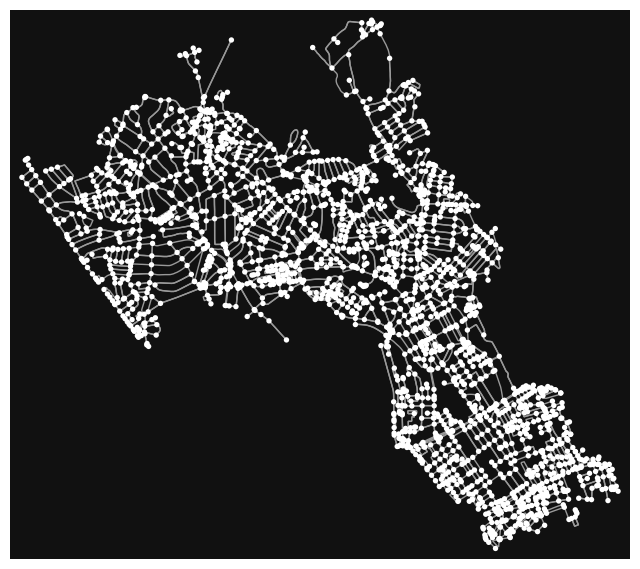

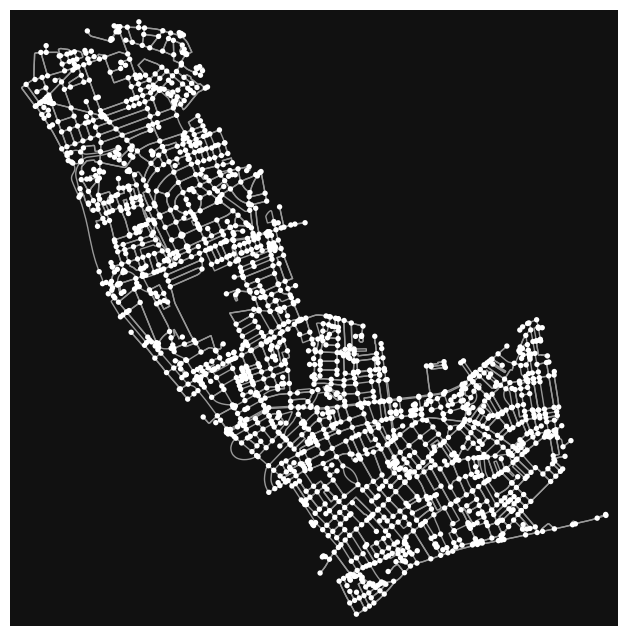

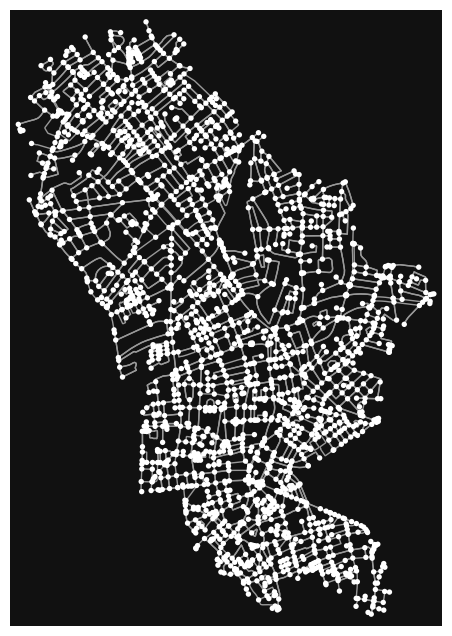

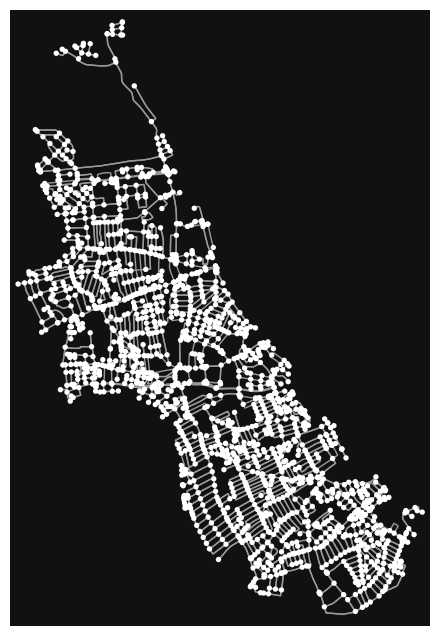

In [11]:

# Specify a smaller area within London
place_name = "Camden, London, England, United Kingdom"
# Fetch OSM street network for the specified area
graph = ox.graph_from_place(place_name, network_type='drive')
# Save and load the graph
ox.io.save_graphml(graph, 'Camden.graphml')
graph = ox.io.load_graphml('Camden.graphml')
# Plot the graph
fig, ax = ox.plot_graph(graph)

# Specify a smaller area within London
place_name = "Kensington and Chelsea, London, England, United Kingdom"
# Fetch OSM street network for the specified area
graph = ox.graph_from_place(place_name, network_type='drive')
# Save and load the graph
ox.io.save_graphml(graph, 'Kensington and Chelsea.graphml')
graph = ox.io.load_graphml('Kensington and Chelsea.graphml')
# Plot the graph
fig, ax = ox.plot_graph(graph)

# Specify a smaller area within London
place_name = "Islington, London, England, United Kingdom"
# Fetch OSM street network for the specified area
graph = ox.graph_from_place(place_name, network_type='drive')
# Save and load the graph
ox.io.save_graphml(graph, 'Islington.graphml')
graph = ox.io.load_graphml('Islington.graphml')
# Plot the graph
fig, ax = ox.plot_graph(graph)

# Specify a smaller area within London
place_name = "Hammersmith and Fulham, London, England, United Kingdom"
# Fetch OSM street network for the specified area
graph = ox.graph_from_place(place_name, network_type='drive')
# Save and load the graph
ox.io.save_graphml(graph, 'Hammersmith & Fulham.graphml')
graph = ox.io.load_graphml('Hammersmith & Fulham.graphml')
# Plot the graph
fig, ax = ox.plot_graph(graph)

In [12]:
df_boroughs = pd.read_csv('london-borough-profiles-2016 Data set.csv')
df_boroughs.groupby(['Area name'])['Unemployment rate (2015)']

#clean data for only showing the rows for Westminster, Camden, Kensington and Chelsea, Islington, and Hammersmith and Fulham
#use is in to filter out certain rows?
df_boroughs = df_boroughs.loc[df_boroughs['Area name'].isin(['Westminster', 'Camden', 'Kensington and Chelsea', 'Islington', 'Hammersmith and Fulham'])]
df_boroughs

,Code,New code,Area name,Inner/ Outer London,GLA Population Estimate 2016,GLA Household Estimate 2016,Inland Area (Hectares),Population density (per hectare) 2016,"Average Age, 2016","Proportion of population aged 0-15, 2016",...,Happiness score 2011-14 (out of 10),Anxiety score 2011-14 (out of 10),Childhood Obesity Prevalance (%) 2014/15,People aged 17+ with diabetes (%),Mortality rate from causes considered preventable 2012/14,Political control in council,Proportion of seats won by Conservatives in 2014 election,Proportion of seats won by Labour in 2014 election,Proportion of seats won by Lib Dems in 2014 election,Turnout at 2014 local elections
7,E09000007,E09000007,Camden,Inner London,"240,595","106,518","2,178.9",109.8,36.2,8.8,...,7.11,3.61,20.8,3.9,163.8,Lab,22.2,74.1,1.9,38.7
13,E09000013,E09000013,Hammersmith and Fulham,Inner London,"183,354","82,513","1,639.7",111.8,35.6,17.0,...,7.16,3.09,23.3,4.4,187.4,Lab,43.5,56.5,0.0,37.6
19,E09000019,E09000019,Islington,Inner London,"228,397","103,612","1,485.7",153.0,34.7,16.0,...,7.06,3.70,22.8,5.0,202.8,Lab,0.0,97.9,0.0,38.4
20,E09000020,E09000020,Kensington and Chelsea,Inner London,"158,447","79,735","1,212.4",129.2,39.1,15.9,...,7.56,3.10,21.5,4.2,136.3,Cons,74.0,24.0,2.0,29.8
33,E09000033,E09000033,Westminster,Inner London,"239,862","117,509","2,148.7",110.4,37.6,15.3,...,7.13,3.43,24.5,4.4,161.5,Cons,73.3,26.7,0.0,32.3
